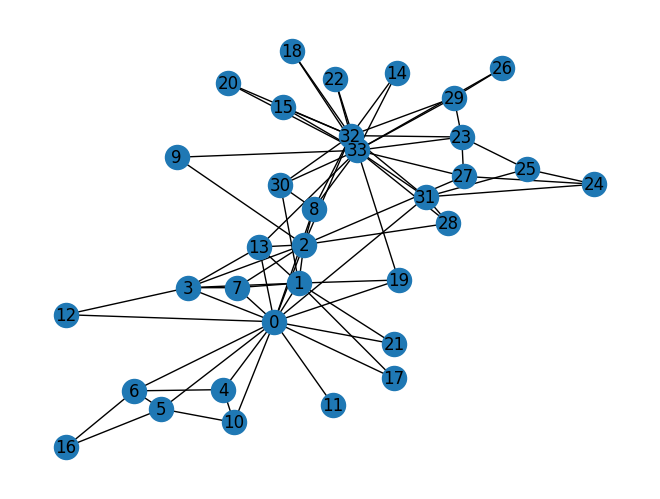

In [1]:
# https://colab.research.google.com/drive/1b6X0m_BNH6Vld3hMMJx3TPO3nWXn8enq?authuser=1#scrollTo=_LCoIkarhfYD

import networkx as nx
import matplotlib.pyplot as plt

### 1

G = nx.karate_club_graph()
# print(type(G)) # <class 'networkx.classes.graph.Graph'>

G = nx.Graph(G) # needed for VSCode typing/param hints
# print(type(G)) # <class 'networkx.classes.graph.Graph'>

nx.draw(G, with_labels = True)
#plt.show()

total_deg = 0
for (_, deg) in G.degree:
    total_deg += deg

# print(total_deg/G.number_of_nodes())


def average_degree(num_edges, num_nodes):
    avg_degree = 2*num_edges/num_nodes
    return round(avg_degree)

# print(average_degree(G.number_of_edges(), G.number_of_nodes()))


def avg_clustering_coefficient(G):
    total_cc = sum(nx.clustering(G).values())
    return round(total_cc/G.number_of_nodes(), 2)

# print(avg_clustering_coefficient(G))


def one_iter_pagerank(G, node_id):
    return nx.pagerank(G)[node_id]

# print(one_iter_pagerank(G, 0))



In [11]:
### 3

import torch
import torch.nn as nn

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
#print(f'Sample embedding layer: {emb_sample}') # Embedding(4, 8)

# .LongTensor = .int64
id  = torch.LongTensor([1]) # tensor([1]) 

# Select an embedding in the sample
#print(id, emb_sample(id)) # tensor([[ 0.2834, ..., 0.0071]], grad_fn=<EmbeddingBackward0>)

# Get shape of embedding weight matrix 
shape = emb_sample.weight.data.shape
#print(shape) # torch.Size([4, 8])

# Check if emb is indeed initialized
ids = torch.LongTensor([0, 3])
#print(emb_sample(ids))


# Create node embedding matrix for G - init uniform dist
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    '''
    Returns (torch.nn.Embedding layer) node embedding matrix. 
    '''
    emb = nn.Embedding(
        num_node, 
        embedding_dim, 
        _weight=torch.rand(num_node, embedding_dim)
        )
    
    # same: emb.weight.data.uniform_(0, 1) # _ means operation performed in-place 
    # same: nn.init.uniform_(emb.weight, 0, 1)

    return emb

emb = create_node_emb()
print(emb.weight.data.shape)
print(emb.weight.data)

# An example that gets the embeddings for first and last node in G
ids = torch.LongTensor([0, 33])
# print(emb(ids))


torch.Size([34, 16])
tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999, 0.3971, 0.7544, 0.5695,
         0.4388, 0.6387, 0.5247, 0.6826, 0.3051, 0.4635, 0.4550],
        [0.5725, 0.4980, 0.9371, 0.6556, 0.3138, 0.1980, 0.4162, 0.2843, 0.3398,
         0.5239, 0.7981, 0.7718, 0.0112, 0.8100, 0.6397, 0.9743],
        [0.8300, 0.0444, 0.0246, 0.2588, 0.9391, 0.4167, 0.7140, 0.2676, 0.9906,
         0.2885, 0.8750, 0.5059, 0.2366, 0.7570, 0.2346, 0.6471],
        [0.3556, 0.4452, 0.0193, 0.2616, 0.7713, 0.3785, 0.9980, 0.9008, 0.4766,
         0.1663, 0.8045, 0.6552, 0.1768, 0.8248, 0.8036, 0.9434],
        [0.2197, 0.4177, 0.4903, 0.5730, 0.1205, 0.1452, 0.7720, 0.3828, 0.7442,
         0.5285, 0.6642, 0.6099, 0.6818, 0.7479, 0.0369, 0.7517],
        [0.1484, 0.1227, 0.5304, 0.4148, 0.7937, 0.2104, 0.0555, 0.8639, 0.4259,
         0.7812, 0.6607, 0.1251, 0.6004, 0.6201, 0.1652, 0.2628],
        [0.6705, 0.5896, 0.2873, 0.3486, 0.9579, 0.4075, 0.7819, 0.7165, 0.1768,
         0.0748,

In [26]:
### Visualize emb in 2D space with PCA
from sklearn.decomposition import PCA

def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    print(components)

    plt.figure(figsize=(6, 6))
    group1_x = []
    group1_y = []
    group2_x = []
    group2_y = []

    # entire node attribute dict (n, ddict) io just nodes n.
    for node in G.nodes(data=True): 
        if node[1]['club'] == 'Mr. Hi':
            group1_x.append(components[node[0]][0])
            group1_y.append(components[node[0]][1])
        else:
            group2_x.append(components[node[0]][0])
            group2_y.append(components[node[0]][1])
    plt.scatter(group1_x, group1_y, color="red", label="Mr. Hi")
    plt.scatter(group2_x, group2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()

# visualize_emb(emb)


### 7: Training the embedding for classifying edges as +ve/-ve
# +ve means edge exists, -ve means edge DNE

from torch.optim import SGD
import torch.nn as nn

def list_to_tensor(a_list):
    '''
    inputs list of x edges
    returns tensor of shape (2, x)
    '''
    a_tensor = torch.LongTensor(a_list)
    return a_tensor.t()


#print("edge tensors", pos_edge_index, neg_edge_index)


def accuracy(pred, label):
    """
    pred: (tensor) after sigmoid
    label: (torch.LongTensor)

    if pred > 0.5, class as label 1, else label 0

    returns accuracy (float) rounded to 4dp
    """

    pred_labels = (pred > 0.5).float()

    correct = (pred_labels == label).float().sum()

    accuracy = correct / label.shape[0]

    # item() returns single-value tensor as number
    accuracy = round(accuracy.item(), 4)

    return accuracy


def train(emb, loss_fn, sigmoid, train_labels, train_edges):
    
    epochs = 500
    lr = .2
    optimizer = SGD(emb.parameters(), lr=lr, momentum=.99)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Embs of first node of each edge
        emb_node_1 = emb(train_edges[0]) # shape [78, 16]
        # Embs of second node of each edge
        emb_node_2 = emb(train_edges[1]) # shape [78, 16]
        # shapes of emb_node_x is [#edges, emb_dim=16]


        # Dot product the embeddings between each node pair
        dot_prod = (emb_node_1 * emb_node_2).sum(dim=1) # shape [78]

        # Feed the dot product result into sigmoid
        preds = sigmoid(dot_prod)

        # Feed sigmoid output into loss_fn
        loss = loss_fn(preds, train_labels) # train_labels.float()

        # Update emb with backpropagation
        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs
        # (as a sanity check, the loss should decrease during training)
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, "
                  f"Loss: {loss.item():.2f}, "
                  f"Accuracy: {accuracy(preds, train_labels):.2f}")

In [27]:
pos_edge_list = []
for edge in G.edges():
    pos_edge_list.append(edge)

neg_edge_list = []
K_34_edges = [(a, b) for a in range(34) for b in range(34) if b > a] 

for tuple in K_34_edges:
    if tuple not in pos_edge_list:
        neg_edge_list.append(tuple)

pos_edge_index = list_to_tensor(pos_edge_list)
neg_edge_index = list_to_tensor(neg_edge_list)

print(pos_edge_index.shape)
print(torch.sum(pos_edge_index))

# Generate the +ve and -ve labels
pos_labels = torch.ones(pos_edge_index.shape[1])
neg_labels = torch.zeros(neg_edge_index.shape[1])
train_labels = torch.cat([pos_labels, neg_labels], dim=0)
print(f"pos_labels {pos_labels.shape}, neg_labels {neg_labels.shape}")
print("train_labs", train_labels.shape)

# Since the network is very small, we do not split the edges into val/test sets
print(pos_edge_index.shape)
train_edges = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print("train_edges", train_edges.shape)

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

train(emb, loss_fn, sigmoid, train_labels, train_edges)

torch.Size([2, 78])
tensor(2535)
pos_labels torch.Size([78]), neg_labels torch.Size([483])
train_labs torch.Size([561])
torch.Size([2, 78])
train_edges torch.Size([2, 561])
Epoch 1/500, Loss: 0.03, Accuracy: 0.99
Epoch 11/500, Loss: 0.03, Accuracy: 0.99
Epoch 21/500, Loss: 0.03, Accuracy: 0.99
Epoch 31/500, Loss: 0.03, Accuracy: 0.99
Epoch 41/500, Loss: 0.03, Accuracy: 0.99
Epoch 51/500, Loss: 0.03, Accuracy: 0.99
Epoch 61/500, Loss: 0.03, Accuracy: 0.99
Epoch 71/500, Loss: 0.03, Accuracy: 0.99
Epoch 81/500, Loss: 0.03, Accuracy: 0.99
Epoch 91/500, Loss: 0.03, Accuracy: 0.99
Epoch 101/500, Loss: 0.03, Accuracy: 0.99
Epoch 111/500, Loss: 0.03, Accuracy: 0.99
Epoch 121/500, Loss: 0.03, Accuracy: 0.99
Epoch 131/500, Loss: 0.03, Accuracy: 0.99
Epoch 141/500, Loss: 0.03, Accuracy: 0.99
Epoch 151/500, Loss: 0.03, Accuracy: 0.99
Epoch 161/500, Loss: 0.03, Accuracy: 0.99
Epoch 171/500, Loss: 0.03, Accuracy: 0.99
Epoch 181/500, Loss: 0.03, Accuracy: 0.99
Epoch 191/500, Loss: 0.03, Accuracy: 0.9

[[-3.6889296  -2.5532234 ]
 [-2.4534576  -3.0351732 ]
 [-2.986602   -6.319764  ]
 [-3.2137468  -5.323803  ]
 [-3.08179    -0.6246136 ]
 [-8.303193   10.826762  ]
 [-8.606498   10.944622  ]
 [-3.3157818  -5.2425795 ]
 [ 2.8041174  -2.666583  ]
 [-2.5696263  -2.8169627 ]
 [-2.8939028  -0.70132196]
 [-1.2273861  -0.89197636]
 [-1.6141058  -1.9535804 ]
 [-2.4279642  -5.1646166 ]
 [ 0.26548576 -0.30488166]
 [ 0.26548746 -0.3048807 ]
 [-7.729466   10.28692   ]
 [-1.2487245  -0.5203366 ]
 [ 0.2654863  -0.304882  ]
 [-0.7702366  -0.74574375]
 [ 0.2654862  -0.3048817 ]
 [-1.545969   -0.21034767]
 [ 2.745753   -2.1743426 ]
 [ 2.8925169  -0.6919674 ]
 [ 9.733513    6.3807335 ]
 [10.804728    7.22658   ]
 [ 0.07770108 -1.564208  ]
 [ 2.2515402  -1.0239286 ]
 [ 3.7599702   0.8168842 ]
 [ 0.5604296  -1.6135983 ]
 [ 2.9500756  -2.3436787 ]
 [ 9.96404     5.8761296 ]
 [ 3.8715043  -1.423986  ]
 [ 4.199549   -1.5327704 ]]


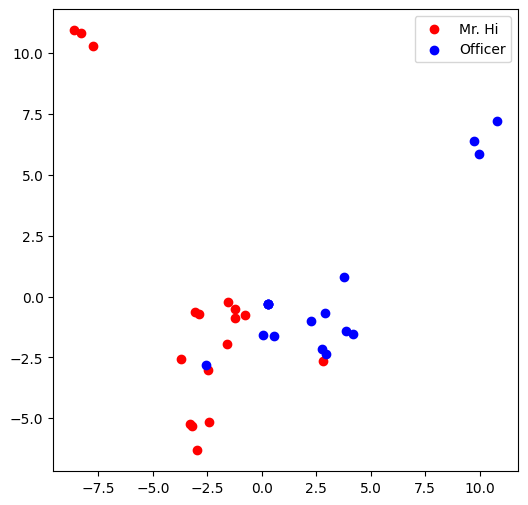

In [28]:
visualize_emb(emb)